In [6]:
# === 1. Import libraries ===
import pandas as pd
import numpy as np
import joblib
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 150)

In [7]:
# === 2. Load trained model and raw data ===
rf_model = joblib.load('../data/final/nba_rf_model.pkl')
print("✅ Model loaded successfully!")

# Load necessary datasets
games = pd.read_csv('../data/raw/Games.csv', low_memory=False)
team_stats = pd.read_csv('../data/raw/TeamStatistics.csv', low_memory=False)

# Convert dates
games['gameDate'] = pd.to_datetime(games['gameDate'], errors='coerce', utc=True)

✅ Model loaded successfully!


In [8]:
# === 3. Filter real games played between Oct 21–30, 2025 ===
start_date = pd.Timestamp("2025-10-21", tz='UTC')
end_date = pd.Timestamp("2025-10-30", tz='UTC')

mask = (games['gameDate'] >= start_date) & (games['gameDate'] <= end_date)
recent_games = games.loc[
    mask, 
    ['gameId', 'gameDate', 'hometeamId', 'awayteamId', 'hometeamName', 'awayteamName', 'homeScore', 'awayScore']
].copy()

print(f"🏀 Games selected for backtesting: {recent_games.shape[0]}")
display(recent_games.head())

🏀 Games selected for backtesting: 58


,gameId,gameDate,hometeamId,awayteamId,hometeamName,awayteamName,homeScore,awayScore
0,22500127,2025-10-28 23:00:00+00:00,1610612744,1610612746,Warriors,Clippers,98,79
1,22500126,2025-10-28 20:00:00+00:00,1610612760,1610612758,Thunder,Kings,107,101
2,22500125,2025-10-28 20:00:00+00:00,1610612749,1610612752,Bucks,Knicks,121,111
3,22500124,2025-10-28 19:30:00+00:00,1610612748,1610612766,Heat,Hornets,144,117
4,22500123,2025-10-28 19:00:00+00:00,1610612764,1610612755,Wizards,76ers,134,139


In [9]:
# === 4. Merge each game with team statistics (optimized version) ===

# Detect season column
possible_season_cols = [c for c in team_stats.columns if "season" in c.lower()]
print(f"Detected season columns: {possible_season_cols}")

season_col = possible_season_cols[0] if possible_season_cols else None
if season_col:
    team_stats = team_stats[team_stats[season_col] == 2025]

# Index by teamId for fast join
if 'teamId' not in team_stats.columns:
    raise KeyError("Column 'teamId' not found in team_stats.")

team_stats.set_index('teamId', inplace=True)

# Add prefixes
home = team_stats.add_prefix('home_')
away = team_stats.add_prefix('away_')

# Merge
merged = (
    recent_games
    .merge(home, left_on='hometeamId', right_index=True, how='left')
    .merge(away, left_on='awayteamId', right_index=True, how='left')
)

print(f"⚡ Merge completed successfully: {merged.shape}")
display(merged.head(3))

Detected season columns: ['seasonWins', 'seasonLosses']
⚡ Merge completed successfully: (58, 102)


,gameId,gameDate,hometeamId,awayteamId,hometeamName,awayteamName,homeScore,awayScore,home_gameId,home_gameDate,home_teamCity,home_teamName,home_opponentTeamCity,home_opponentTeamName,home_opponentTeamId,home_home,home_win,home_teamScore,home_opponentScore,home_assists,home_blocks,home_steals,home_fieldGoalsAttempted,home_fieldGoalsMade,home_fieldGoalsPercentage,home_threePointersAttempted,home_threePointersMade,home_threePointersPercentage,home_freeThrowsAttempted,home_freeThrowsMade,home_freeThrowsPercentage,home_reboundsDefensive,home_reboundsOffensive,home_reboundsTotal,home_foulsPersonal,home_turnovers,home_plusMinusPoints,home_numMinutes,home_q1Points,home_q2Points,home_q3Points,home_q4Points,home_benchPoints,home_biggestLead,home_biggestScoringRun,home_leadChanges,home_pointsFastBreak,home_pointsFromTurnovers,home_pointsInThePaint,home_pointsSecondChance,home_timesTied,home_timeoutsRemaining,home_seasonWins,home_seasonLosses,home_coachId,away_gameId,away_gameDate,away_teamCity,away_teamName,away_opponentTeamCity,away_opponentTeamName,away_opponentTeamId,away_home,away_win,away_teamScore,away_opponentScore,away_assists,away_blocks,away_steals,away_fieldGoalsAttempted,away_fieldGoalsMade,away_fieldGoalsPercentage,away_threePointersAttempted,away_threePointersMade,away_threePointersPercentage,away_freeThrowsAttempted,away_freeThrowsMade,away_freeThrowsPercentage,away_reboundsDefensive,away_reboundsOffensive,away_reboundsTotal,away_foulsPersonal,away_turnovers,away_plusMinusPoints,away_numMinutes,away_q1Points,away_q2Points,away_q3Points,away_q4Points,away_benchPoints,away_biggestLead,away_biggestScoringRun,away_leadChanges,away_pointsFastBreak,away_pointsFromTurnovers,away_pointsInThePaint,away_pointsSecondChance,away_timesTied,away_timeoutsRemaining,away_seasonWins,away_seasonLosses,away_coachId
0,22500127,2025-10-28 23:00:00+00:00,1610612744,1610612746,Warriors,Clippers,98,79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,22500126,2025-10-28 20:00:00+00:00,1610612760,1610612758,Thunder,Kings,107,101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,22500125,2025-10-28 20:00:00+00:00,1610612749,1610612752,Bucks,Knicks,121,111,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# === 5. Feature engineering ===

# Create target column from real results
merged['home_win'] = (merged['homeScore'] > merged['awayScore']).astype(int)

# Create difference features (home - away)
diff_features = []
for col in merged.columns:
    if col.startswith('home_') and col.replace('home_', 'away_') in merged.columns:
        diff_col = "diff_" + col.replace('home_', '')
        merged[diff_col] = merged[col] - merged[col.replace('home_', 'away_')]
        diff_features.append(diff_col)

print(f"Created {len(diff_features)} difference features.")

# Select final columns for prediction
X = merged.select_dtypes(include=['float64', 'int64', 'bool']).drop(columns=['home_win', 'homeScore', 'awayScore'], errors='ignore')
y_true = merged['home_win']

print(f"Final feature matrix: {X.shape}")

Created 47 difference features.
Final feature matrix: (58, 128)


In [12]:
# === 6. Align features and run model predictions ===

# --- 6.1 Align columns with model training ---
# Try loading the exact column names used during training
try:
    model_features = joblib.load('../data/final/model_features.pkl')
    print(f"Loaded {len(model_features)} feature names from training.")
except:
    print("⚠️ No saved feature list found — using model's internal feature names if available.")
    model_features = getattr(rf_model, 'feature_names_in_', X.columns.tolist())

# Add any missing columns with 0 (so model input shape matches)
for col in model_features:
    if col not in X.columns:
        X[col] = 0

# Drop any columns not used by the model
X = X[model_features]

print(f"✅ Feature matrix aligned successfully: {X.shape}")

# --- 6.2 Make predictions ---
y_pred = rf_model.predict(X)

# Store results
merged['predicted_win'] = y_pred
merged['correct'] = (merged['home_win'] == merged['predicted_win']).astype(int)

# Compute accuracy
accuracy = round(accuracy_score(y_true, y_pred), 4)
print(f"🏀 Backtest Accuracy: {accuracy}")

# Display preview
display(
    merged[['gameDate', 'hometeamName', 'awayteamName', 
            'homeScore', 'awayScore', 'home_win', 'predicted_win', 'correct']].head(15)
)

⚠️ No saved feature list found — using model's internal feature names if available.
✅ Feature matrix aligned successfully: (58, 87)
🏀 Backtest Accuracy: 0.6034


,gameDate,hometeamName,awayteamName,homeScore,awayScore,home_win,predicted_win,correct
0,2025-10-28 23:00:00+00:00,Warriors,Clippers,98,79,1,1,1
1,2025-10-28 20:00:00+00:00,Thunder,Kings,107,101,1,1,1
2,2025-10-28 20:00:00+00:00,Bucks,Knicks,121,111,1,1,1
3,2025-10-28 19:30:00+00:00,Heat,Hornets,144,117,1,1,1
4,2025-10-28 19:00:00+00:00,Wizards,76ers,134,139,0,1,0
5,2025-10-27 22:30:00+00:00,Lakers,Trail Blazers,108,122,0,1,0
6,2025-10-27 22:00:00+00:00,Warriors,Grizzlies,131,118,1,1,1
7,2025-10-27 21:30:00+00:00,Timberwolves,Nuggets,114,127,0,1,0
8,2025-10-27 21:00:00+00:00,Jazz,Suns,138,134,1,1,1
9,2025-10-27 20:30:00+00:00,Mavericks,Thunder,94,101,0,1,0



📊 Backtest Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        23
           1       0.60      1.00      0.75        35

    accuracy                           0.60        58
   macro avg       0.30      0.50      0.38        58
weighted avg       0.36      0.60      0.45        58



/Users/valenkloster/Desktop/NBA DATASET/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/valenkloster/Desktop/NBA DATASET/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/valenkloster/Desktop/NBA DATASET/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(

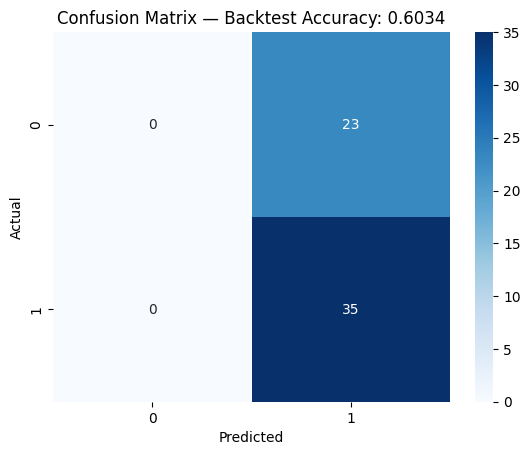

In [13]:
# === 7. Evaluate backtest performance ===

print("\n📊 Backtest Classification Report:")
print(classification_report(y_true, y_pred))

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix — Backtest Accuracy: {accuracy}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [15]:
# === 8. Identify misclassified games ===

wrong_preds = merged[merged['correct'] == 0][
    ['gameDate', 'hometeamName', 'awayteamName', 'homeScore', 'awayScore', 'predicted_win']
].copy()

print(f"Misclassified games: {wrong_preds.shape[0]} / {merged.shape[0]}")
display(wrong_preds.head(20))

Misclassified games: 23 / 58


,gameDate,hometeamName,awayteamName,homeScore,awayScore,predicted_win
4,2025-10-28 19:00:00+00:00,Wizards,76ers,134,139,1
5,2025-10-27 22:30:00+00:00,Lakers,Trail Blazers,108,122,1
7,2025-10-27 21:30:00+00:00,Timberwolves,Nuggets,114,127,1
9,2025-10-27 20:30:00+00:00,Mavericks,Thunder,94,101,1
12,2025-10-27 20:00:00+00:00,Pelicans,Celtics,90,122,1
14,2025-10-27 19:00:00+00:00,Pistons,Cavaliers,95,116,1
16,2025-10-26 21:00:00+00:00,Kings,Lakers,120,127,1
22,2025-10-26 18:00:00+00:00,Wizards,Hornets,113,139,1
27,2025-10-25 19:30:00+00:00,Hawks,Thunder,100,117,1
29,2025-10-25 19:00:00+00:00,Magic,Bulls,98,110,1


In [16]:
# === 9. Summary ===

total_games = merged.shape[0]
correct_games = merged['correct'].sum()
accuracy_pct = round(100 * correct_games / total_games, 2)

home_pred_rate = merged['predicted_win'].mean() * 100
real_home_win_rate = merged['home_win'].mean() * 100

print(f"""
🏁 SUMMARY — BACKTEST (Oct 21–30, 2025)
-------------------------------------
Total games analyzed: {total_games}
Correct predictions: {correct_games} ({accuracy_pct}%)
Predicted home wins: {home_pred_rate:.1f}%
Actual home wins:   {real_home_win_rate:.1f}%
""")


🏁 SUMMARY — BACKTEST (Oct 21–30, 2025)
-------------------------------------
Total games analyzed: 58
Correct predictions: 35 (60.34%)
Predicted home wins: 100.0%
Actual home wins:   60.3%



In [20]:
import pandas as pd

games = pd.read_csv("../data/raw/Games.csv", low_memory=False)
games['gameDate'] = pd.to_datetime(games['gameDate'], errors='coerce', utc=True)

future_games = games[
    (games['gameDate'].dt.date == pd.Timestamp("2025-10-29").date()) &
    (games['homeScore'].isna()) & (games['awayScore'].isna())
][['gameDate', 'hometeamName', 'awayteamName']]

print(f"Future games on Oct 29: {len(future_games)}")
display(future_games.head(20))

Future games on Oct 29: 0


,gameDate,hometeamName,awayteamName
